In [1]:
import torch
import numpy as np
import time

import quairkit as qkit
from quairkit import Circuit
from quairkit.database import *
from quairkit.qinfo import *
from quairkit.core import to_state


qkit.set_dtype('complex128')

In [2]:
def JA(gamma:float):
    return (1/2) * torch.tensor([[1, 0, 0, np.sqrt(1-gamma)],
                                 [0, 0, 0, 0],
                                 [0, 0, gamma, 0],
                                 [np.sqrt(1-gamma), 0, 0, 1-gamma]]) + 0.0j

In [3]:
# circuit functions
na1 = 2
na2 = na1

cir_J1 = Circuit(1+1+na1+2)
cir_J1.universal_qudits(list(range(1, 1+1+na1+2)))

cir_J2 = Circuit(1+1+na2+2)
cir_J2.universal_qudits(list(range(1, 1+1+na2+2)))

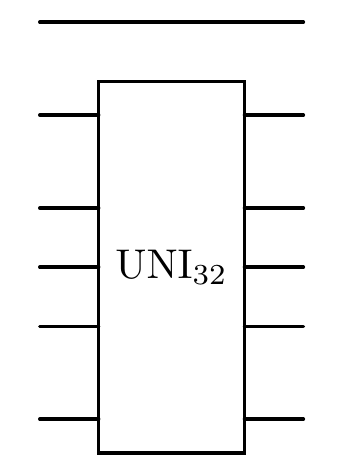

In [4]:
cir_J1.plot()

In [5]:
p1 = 1.5
p2 = 0.5
sample = 1000
gamma = np.linspace(0.0, 1.0, sample)

mes = bell_state(2).density_matrix
ans_state = zero_state(na1).density_matrix

initial_state = []
target_dens = []
for _ in range(sample):
    initial_state.append(NKron(mes,ans_state, JA(gamma[_])))
    target_dens.append(2*JA(gamma[_]))

initail_state = to_state(torch.stack(initial_state))
target_dens = torch.stack(target_dens)


In [ ]:
LR= 0.1
num_itr=1000

loss_list, time_list = [], []

# cir is a Circuit type
opt = torch.optim.Adam(lr=LR, params=list(cir_J1.parameters()) + list(cir_J2.parameters()))

# activate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, "min", factor=0.5)

print("Training:")
for itr in range(num_itr):
    start_time = time.time()
    opt.zero_grad()
    
    # compute loss
    state_1 = cir_J1(initail_state).trace(list(range(2, 2+na1+2)))
    state_2 = cir_J2(initail_state).trace(list(range(2, 2+na1+2)))
    
    output = p1*state_1.density_matrix - p2*state_2.density_matrix

    loss = torch.norm(output - target_dens).mean()  # compute loss

    loss.backward()  # compute gradients
    opt.step()  # update parameters

    loss = loss.item()
    scheduler.step(loss)  # activate scheduler

    loss_list.append(loss)
    time_list.append(time.time() - start_time)

    if itr % 100 == 0 or itr == num_itr - 1:
        print(f"iter: {itr}, loss: {loss:.8f}, "
                f"lr: {scheduler.get_last_lr()[0]:.2E} "
                f"avg_time: {np.mean(time_list):.4f}s")
        time_list = []


Training:
iter: 0, loss: 43.55477952, lr: 1.00E-01 avg_time: 1.0975s
iter: 100, loss: 17.26889566, lr: 1.00E-01 avg_time: 0.8176s
iter: 200, loss: 17.24765788, lr: 6.25E-03 avg_time: 0.8013s
iter: 300, loss: 17.24738381, lr: 1.22E-05 avg_time: 0.7932s
